A version of googlenet that runs on keras.

Copied from here:
https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14


The example image is called cat.jpg. Any jpg should do.

There's a (very rudimentary and hacked together) max patch visualization at the bottom of the document.

In [1]:
from googlenet import *
import numpy as np

Using Theano backend.


In [2]:
img = imresize(imread('cat.jpg', mode='RGB'), (224, 224)).astype(np.float32)
img[:, :, 0] -= 123.68
img[:, :, 1] -= 116.779
img[:, :, 2] -= 103.939
img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
img = img.transpose((2, 0, 1))
img = np.expand_dims(img, axis=0)

# Test pretrained model
model = create_googlenet('googlenet_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')
out = model.predict(img) # note: the model has three outputs
print(np.argmax(out[2]))

287


In [3]:
synset_words = open('synset_words.txt', 'rb')
class_names = []
for line in synset_words:
    class_names.append(line[9:-1].decode('UTF-8'))
synset_words.close()




In [4]:
out = model.predict(img) # note: the model has three outputs
print(np.argmax(out[2]))
print(class_names[np.argmax(out[2])])

287
 lynx, catamount


In [217]:
import json
parsed = json.loads(model.to_json())

#print(json.dumps(parsed, indent=4, sort_keys=True))
parsed['config']['layers']

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': [None, 3, 224, 224],
   'input_dtype': 'float32',
   'name': 'input_3'},
  'inbound_nodes': [],
  'name': 'input_3'},
 {'class_name': 'Convolution2D',
  'config': {'W_constraint': None,
   'W_regularizer': {'l1': 0.0,
    'l2': 0.00019999999494757503,
    'name': 'WeightRegularizer'},
   'activation': 'relu',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'bias': True,
   'border_mode': 'same',
   'dim_ordering': 'th',
   'init': 'glorot_uniform',
   'name': 'conv1/7x7_s2',
   'nb_col': 7,
   'nb_filter': 64,
   'nb_row': 7,
   'subsample': [2, 2],
   'trainable': True},
  'inbound_nodes': [[['input_3', 0, 0]]],
  'name': 'conv1/7x7_s2'},
 {'class_name': 'ZeroPadding2D',
  'config': {'name': 'zeropadding2d_9', 'padding': [1, 1], 'trainable': True},
  'inbound_nodes': [[['conv1/7x7_s2', 0, 0]]],
  'name': 'zeropadding2d_9'},
 {'class_name': 'PoolHelper',
  'config': {'name': 'poolhelp

In [9]:
## Now doing a viz!

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np




def get_max_location(result, filter_number):
    a = result[0][filter_number]
    return np.unravel_index(a.argmax(), a.shape)

# Not sure 'bout this calculation at all.
def get_max_patch(result, filter_number, image):
    max_location = get_max_location(result, filter_number)
    width_ratio = 2#image.shape[1] / result.shape[3]
    height_ratio = 2#image.shape[0] / result.shape[2]
    patch_top = int(max_location[0] * height_ratio-4)
    patch_left = int(max_location[1] * width_ratio-4)
    return image[patch_top:patch_top+8, patch_left:patch_left+8]

def get_max_value(result, filter_number):
    max_location = get_max_location(result, filter_number)
    return result[0][filter_number][max_location[0], max_location[1]]


def max_patches(dataset, predictions=np.array([]), filter_number=0, n=9):
    # Note: no more than 1 patch per image... not mathematically sound, but works well enough.
    if predictions.shape[0] != dataset.shape[0]:
        predictions = model.predict_on_batch(dataset)

    maxes = [-get_max_value([p], filter_number) for p in predictions]
    order = np.argsort(maxes)
    
    max_patches = [
        get_max_patch(np.array([predictions[max_image]]), filter_number, dataset[max_image][0])
        for max_image in order[:n]
    ]
    return max_patches




In [5]:
#from keras.models import Sequential, load_model
#Sequential().fork
from keras import backend as K
LAYER = 3
FILTER = 2

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[LAYER].output])
layer_output = get_3rd_layer_output([img])[0]
original_image = mpimg.imread("cat.jpg")


plt.figure(figsize=(10, 10))


filter_shape = layer_output[FILTER][0].shape
squished_image_shape = img[0,:,:][0].shape
original_image_shape = original_image.shape

y_filter, x_filter = get_max_location(layer_output, FILTER)

## Draw the filter's output
plt.subplot(1,3,1)
plt.imshow(layer_output[0][0])
plt.plot(x_filter, y_filter, 'go')

## Draw the squished image:
x_squished = x_filter*squished_image_shape[1]/filter_shape[1]
y_squished = y_filter*squished_image_shape[0]/filter_shape[0]
plt.subplot(1,3,2)
plt.imshow(img[0,:,:][0], cmap='gray')
plt.plot(x_squished, y_squished, 'go')


## Draw the original image
plt.subplot(1,3,3)
# Compute percentage
x_original = x_filter*original_image_shape[1]/filter_shape[1]
y_original = y_filter*original_image_shape[0]/filter_shape[0]
plt.imshow(original_image)
plt.plot(x_original, y_original, 'go')


print('\nJoy...</sarcasm> reading the image in different ways gets different shapes:',
      mpimg.imread("cat.jpg").shape,
      img.shape)


plt.figure()
patch_size = 30 //2
plt.imshow(original_image[y_original-patch_size:y_original+patch_size,
                          x_original-patch_size:x_original+patch_size])

NameError: name 'mpimg' is not defined

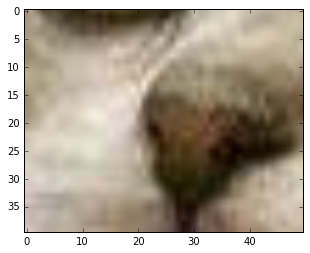

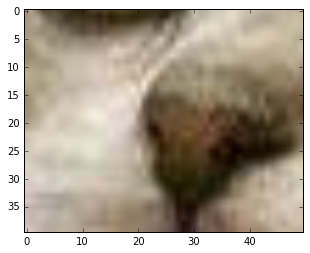

In [156]:
## Multipurpose max patch functions

from keras import backend as K

# Tested/built for Theano... should be tensorflow compatible
def max_patch(model, data, images=None, layer_number=-1, filter_number=0, number_of_patches=9, patch_size=(8,8)):
    
    # images are unpreprocessed data
    if images == None:
        images = data
    
    # Has shape (1), where each element is the layer's output.
    # A typical layer's output is (1, filters, width, height)
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[layer_number].output])
    
    # List of np.arrays(shape=(width, height))
    outputs = [get_layer_output([inputs])[0][0][filter_number] for inputs in data]
    
    # Get the maximum values
    maxes = [output.argmax() for output in outputs]
    
    # The indices of the images with the n highest maxes
    image_indices = np.argsort(maxes)[:number_of_patches]
    
    max_outputs = [ outputs[index] for index in image_indices]
    
    # Maximum locations in each 'image'
    # list of (x, y) locations... (technically, (x,y,z,q) locations are fine too)
    max_locations = [np.unravel_index(output.argmax(), output.shape) for output in max_outputs]

    
    # Works for multidimensional input
    # Get the location of the centers as fractions (between 0 and 1)
    # List of (index, (x,y)) where 0 < x < 1
    #fractional_centers = []    
    #for index in range(len(outputs)):
    #    fractions = [loc/total for loc, total in zip(max_locations[index], outputs[index].shape)]
    #    fractional_centers.append(tuple(fractions))    
    
    
    
    # Works only for 2D images
    def patch_from_location(image, max_location, patch_size):
        x = int(max_locations[0][1]/outputs[0].shape[1]*images[0].shape[1])
        y = int(max_locations[0][0]/outputs[0].shape[0]*images[0].shape[0])
        top = y-patch_size[0]//2
        left = x-patch_size[1]//2
        return image[top:top+patch_size[0],
                     left:left+patch_size[1]]
    
    patches = [patch_from_location(images[index], max_locations[index], patch_size)
            for index in range(len(images))]
    
    return patches




%matplotlib inline
import matplotlib.pyplot as plt

# GoogLeNet preprocesses images and messes with their dimensions, which makes it a pain to use matplotlib.
# This allows us to create patches that are easy to plot
import matplotlib.image as mpimg

original_image = mpimg.imread("cat.jpg")

data = [img]*2 # input to the neural net
images = [original_image]*2 # Used for generating patches - we cannot call plt.imshow(data[0])

patches = max_patch(model, data, images, 2, patch_size=(40,50))

for patch in patches:
    plt.figure()
    plt.imshow(patch)

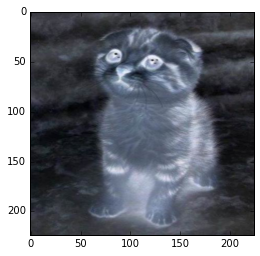

In [192]:
img = imresize(imread('cat.jpg', mode='RGB'), (224, 224)).astype(np.float32)
img[:, :, 0] -= 123.68
img[:, :, 1] -= 116.779
img[:, :, 2] -= 103.939
img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
img = img.transpose((2, 0, 1))
img = np.expand_dims(img, axis=0)
img.shape

img[0].shape
img = img[0].transpose((1,2,0))
img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
img[:, :, 0] += 123.68
img[:, :, 1] += 116.779
img[:, :, 2] += 103.939
img.shape
plt.imshow(img)

In [256]:

# img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
# img = img.transpose((2, 0, 1))
# img = np.expand_dims(img, axis=0)




x = np.array([
    [[1,2,3], [4,5,6], [1.5,2.5,3.5]],
    [[7,8,9], [10,11,12], [1.2,2.2,3.2]]
])
y = x
#x[:,:,[0,1,2]] = x[:,:,[2,1,0]]
print(x)
x=np.array(x).transpose((2,0,1))
print(x.shape)
print(x)
print('\n\nx', x[:,0,0], y[0,0,:])
x.transpose(1,2,0)
#x[:,:,[0,1,2]] = x[:,:,[2,1,0]]
x

[[[  1.    2.    3. ]
  [  4.    5.    6. ]
  [  1.5   2.5   3.5]]

 [[  7.    8.    9. ]
  [ 10.   11.   12. ]
  [  1.2   2.2   3.2]]]
(3, 2, 3)
[[[  1.    4.    1.5]
  [  7.   10.    1.2]]

 [[  2.    5.    2.5]
  [  8.   11.    2.2]]

 [[  3.    6.    3.5]
  [  9.   12.    3.2]]]


x [ 1.  2.  3.] [ 1.  2.  3.]


array([[[  1. ,   4. ,   1.5],
        [  7. ,  10. ,   1.2]],

       [[  2. ,   5. ,   2.5],
        [  8. ,  11. ,   2.2]],

       [[  3. ,   6. ,   3.5],
        [  9. ,  12. ,   3.2]]])